# Outline

- create a model that predicts the category of each article by Recurrent Neural Network with **pre-trained word embeddings**
- train data is `matichon.json` that contains about 17K articles of Thai news by Matichon between 2015-2018
- X is `headline` of news
- y is category (10 labels)
- pre-trained word embedding is `word2vec_matichoon.model` that is trained from the articles
- F1 score of Logistic Regression using headline : **0.71**

# Import

In [1]:
import pandas as pd
import numpy as np
import re, emoji, urllib, html

from keras.layers import Dense, Input, LSTM, Embedding
from keras.models import Sequential
from keras.utils import plot_model, to_categorical, pad_sequences

from gensim.models import Word2Vec

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from pythainlp.tokenize import word_tokenize

- custom tokenization function
- remove all quotations and shrink newlines `\n` and white spaces 

In [41]:
def my_tokenize(text):
    ### REMOVE URL ###
    text = html.unescape(urllib.parse.unquote(text)) # unescape for unicode, unquote for escaped URL
    text = re.sub(r'https?.+?(?:\s|$)', '', text) # remove URL link
    ### REMOVE EMOJI ###
    text = emoji.replace_emoji(text) # remove emoji
    ### REPLACE ###
    text = re.sub(r'[“”„\"]', '', text) # remove double quotations
    text = re.sub(r'[‘’′′′′`\']', '', text) # remove single quotations
    text = re.sub(r'[\n\t\u00a0\xa0\u3000\u2002-\u200a\u202f]+', ' ', text) # shrink whitespaces e.g. good  boy -> good boy
    text = re.sub(r'[\r\u200b\ufeff]+', '', text) # remove non-breaking space
    text = re.sub(r'เเ', 'แ', text)
    ### SHRINK SOME REDUPLICATION ###
    text = re.sub(r'าา+', 'า', text)
    text = re.sub(r'ยย+', 'ย', text)
    text = re.sub(r'ๆๆ+', 'ๆ', text)
    text = re.sub(r'ะะ+', 'ะ', text)
    ### am ###
    text = re.sub(r'ํา','ำ', text) # o + า -> ำ
    text = re.sub(r'\u0E33([\u0E48\u0E49\u0E4A\u0E4B])', r'\1'+'\u0E33', text) # am + tone -> tone + am
    ### TOKENIZE AND FILTERING ###
    tokens = word_tokenize(text, keep_whitespace=False)
    tokens = [token for token in tokens if re.match(r'[A-zก-ไ][A-zก-๙\.]*', token)]
    return tokens

# Load data

- target variable is `category`
- `headline` and `article` are untokenized text

In [42]:
df = pd.read_json('data/matichon.json')

## drop "date", "article", "url", and "id"
df.drop(columns=['date','article','url','id'], inplace=True)

df

,headline,category
0,ซาอุฯจ่อเปิดไฟเขียวให้สิทธิหญิงม่าย-หย่าร้างปก...,foreign
1,"""ไก่อู""ชี้ ตู่-เต้น ไม่ได้มีหน้าที่ตรวจสอบทุจร...",politics
2,"เปิดใจ ""โบว์ แวนดา"" ระหว่างรอยิ้มได้เต็มที่ในว...",entertainment
3,"""นาย ณภัทร"" ปลื้มคนชมแชมป์ขึ้นปกนิตยสารแห่งปี ...",entertainment
4,"คอแทบหัก! แม่ยกแห่คล้องพวงมาลัยักษ์ ""บอย ศิริช...",entertainment
...,...,...
17104,โบว์ ณัฏฐา แจ้งความ พล.ต.อ.ศรีวราห์ ถูกพาดพิง...,politics
17105,ภาพบรรยากาศ ขุดทางระบายน้ำ เร่งนำ 13 ชีวิตออกจ...,region
17106,สนช.ผ่านพ.ร.บ.สงฆ์ 3 วาระรวด พระมหากษัตริย์ทรง...,politics
17107,นานาทรรศนะเพิ่มค่าปรับหมอ 5ล้านบ. สกัดเบี้ยว...,education


In [43]:
## value counts of target variable
df.category.value_counts()

politics         3135
region           2655
crime            2141
local            1938
publicize        1481
foreign          1329
economy          1249
sport            1202
education        1053
entertainment     926
Name: category, dtype: int64

### load pre-trained word embeddings

In [44]:
wv_model = Word2Vec.load("data/word2vec_matichon.model")

# Preprocessing

### tokenize

- it may take more than 2 minutes
- you can save the tokenized file by `df.to_json('XXX.json', orient='records')`

In [45]:
df['tokens'] = df['headline'].apply(my_tokenize)
df.head()

,headline,category,tokens
0,ซาอุฯจ่อเปิดไฟเขียวให้สิทธิหญิงม่าย-หย่าร้างปก...,foreign,"[ซาอุฯ, จ่อ, เปิดไฟเขียว, ให้, สิทธิ, หญิง, ม่..."
1,"""ไก่อู""ชี้ ตู่-เต้น ไม่ได้มีหน้าที่ตรวจสอบทุจร...",politics,"[ไก่อู, ชี้, ตู่, เต้น, ไม่, ได้, มี, หน้าที่,..."
2,"เปิดใจ ""โบว์ แวนดา"" ระหว่างรอยิ้มได้เต็มที่ในว...",entertainment,"[เปิดใจ, โบว์, แวนดา, ระหว่าง, รอ, ยิ้ม, ได้, ..."
3,"""นาย ณภัทร"" ปลื้มคนชมแชมป์ขึ้นปกนิตยสารแห่งปี ...",entertainment,"[นาย, ณ, ภัทร, ปลื้ม, คน, ชม, แชมป์, ขึ้น, ปก,..."
4,"คอแทบหัก! แม่ยกแห่คล้องพวงมาลัยักษ์ ""บอย ศิริช...",entertainment,"[คอ, แทบ, หัก, แม่ยก, แห่, คล้อง, พวงมาลัย, ัก..."


In [46]:
## check min & max length of tokens
print('Min Length:', df['tokens'].apply(len).min())
print('Max Length:', df['tokens'].apply(len).max())

Min Length: 4
Max Length: 110


## indexing & one-hot-encoding

- indexing(label encoding) is a process to convert categorical data into numerical form
~~~python
vocab : {'อร่อย':0, 'ไทย':1,...}
y : {'crime':0, 'economy':1,...}
~~~

- one-hot-encoding is also required for `y` to pass to a NN model

In [50]:
## make vocaburary list
all_vocabs = sorted(set.union(*df['tokens'].apply(set)))
print('total vocab :', len(all_vocabs))

## indexing for vocab
vocab2index = {'<PADDING>':0, '<END>':1} # special symbol for padding and EoS
for i, vocab in enumerate(all_vocabs):
    vocab2index[vocab] = len(vocab2index)

## label encoding for y
y_encoder = LabelEncoder()
y = y_encoder.fit_transform(df['category'])

## one-hot-encoding
y = to_categorical(y, num_classes=len(y_encoder.classes_))

total vocab : 18356


# Create `X` sequence

- max length = 110

In [53]:
X = 

Min Length: 4
Max Length: 122


In [86]:
maxlen = 100

## removing and indexing words
## [['ไป', 'กิน'], [...]] => [[3,10], [...]]
X_train = [[model.wv.key_to_index[token] for token in tokens if token in model.wv.key_to_index]\
           for tokens in train['tokens']]

X_test = [[model.wv.key_to_index[token] for token in tokens if token in model.wv.key_to_index]\
           for tokens in test['tokens']]

## padding
X_train = pad_sequences(X_train, maxlen=maxlen, padding='post')
X_test = pad_sequences(X_test, maxlen=maxlen, padding='post')

## make y 
## 1. to index
## 2. one-hot-encoding e.g. [[0,1,0,0...], [0,0,0,1,...], ]
y_train = [label_2_index[label] for label in train['category']]
y_train = to_categorical(y_train, num_classes=len(label_2_index))
y_test = test['category'] # not need to index

print('TRAIN:', X_train.shape, y_train.shape)
print('TEST :', X_test.shape, y_test.shape)

TRAIN: (14542, 100) (14542, 10)
TEST : (2567, 100) (2567,)


In [87]:
vectors.shape[0]

34716

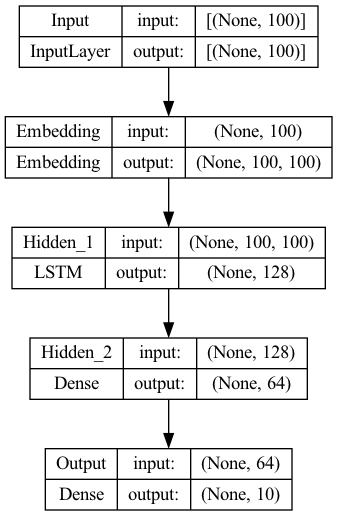

In [88]:
## constants
vectors = model.wv.vectors # use as initial weight of embedding layer
vocab_size = vectors.shape[0]
embedding_dim = vectors.shape[1]
vectors[0] = np.zeros(embedding_dim) # initialize <PADDING> vector with 0

## Instantiate Model
NN = Sequential()
NN.add(Input(shape=(X_train.shape[-1],), name='Input')) # input length
NN.add(Embedding(input_dim=vocab_size,
                    input_length=maxlen,
                    output_dim=embedding_dim,
                    weights = [vectors], # set word embedding as weight, need bracket []
                    trainable = False, # not train word embedding
                    mask_zero=True, # let LSTM ignore padding
                    name = 'Embedding'))
NN.add(LSTM(128, return_sequences=False, name='Hidden_1')) # 1st hidden layer
NN.add(Dense(64, activation='relu', name='Hidden_2'))  # 2nd hidden layer 
NN.add(Dense(10, activation='softmax', name='Output')) # output layer
NN.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics='accuracy')

## plot model
plot_model(NN, show_shapes=True)

In [89]:
NN.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Embedding (Embedding)       (None, 100, 100)          3471600   
                                                                 
 Hidden_1 (LSTM)             (None, 128)               117248    
                                                                 
 Hidden_2 (Dense)            (None, 64)                8256      
                                                                 
 Output (Dense)              (None, 10)                650       
                                                                 
Total params: 3,597,754
Trainable params: 126,154
Non-trainable params: 3,471,600
_________________________________________________________________


# Train

In [90]:
## fit
history = NN.fit(X_train, y_train, epochs=10, validation_split=0.2)

Epoch 1/10
364/364 [==============================] - 19s 46ms/step - loss: 1.1936 - accuracy: 0.5920 - val_loss: 1.0429 - val_accuracy: 0.6428
Epoch 2/10
364/364 [==============================] - 16s 45ms/step - loss: 0.9191 - accuracy: 0.6825 - val_loss: 0.9385 - val_accuracy: 0.6717
Epoch 3/10
364/364 [==============================] - 16s 45ms/step - loss: 0.8353 - accuracy: 0.7057 - val_loss: 0.9298 - val_accuracy: 0.6741
Epoch 4/10
364/364 [==============================] - 16s 45ms/step - loss: 0.7784 - accuracy: 0.7239 - val_loss: 0.8861 - val_accuracy: 0.6796
Epoch 5/10
364/364 [==============================] - 16s 45ms/step - loss: 0.7182 - accuracy: 0.7448 - val_loss: 0.8472 - val_accuracy: 0.7057
Epoch 6/10
364/364 [==============================] - 16s 45ms/step - loss: 0.6669 - accuracy: 0.7586 - val_loss: 0.8606 - val_accuracy: 0.7051
Epoch 7/10
364/364 [==============================] - 16s 45ms/step - loss: 0.6098 - accuracy: 0.7740 - val_loss: 0.9053 - val_accuracy:

<AxesSubplot:xlabel='epoch'>

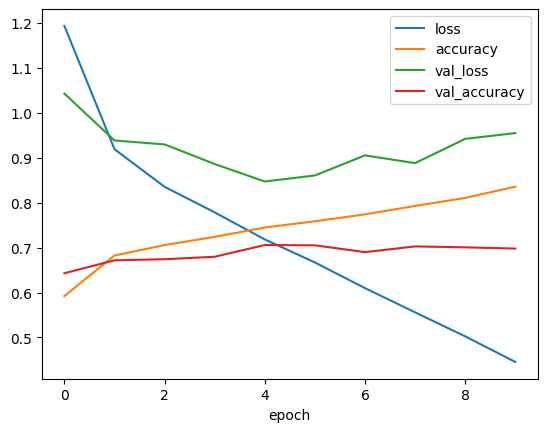

In [91]:
pd.DataFrame(history.history).plot(xlabel='epoch')

- validation loss increased = overfitting
- epoch 4-5 is enough

In [92]:
## train again with all data (no validation split)
NN.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics='accuracy')

history = NN.fit(X_train, y_train, epochs=5, validation_split=0)

Epoch 1/5
455/455 [==============================] - 20s 41ms/step - loss: 0.5298 - accuracy: 0.8092
Epoch 2/5
455/455 [==============================] - 19s 42ms/step - loss: 0.4615 - accuracy: 0.8327
Epoch 3/5
455/455 [==============================] - 19s 41ms/step - loss: 0.4035 - accuracy: 0.8532
Epoch 4/5
455/455 [==============================] - 19s 42ms/step - loss: 0.3440 - accuracy: 0.8738
Epoch 5/5
455/455 [==============================] - 19s 41ms/step - loss: 0.2979 - accuracy: 0.8905


In [93]:
## predict
y_pred = NN.predict(X_test).argmax(axis=1)
y_pred = [index_2_label[i] for i in y_pred]

## print F1 scores
print(classification_report(y_test, y_pred))

81/81 [==============================] - 2s 14ms/step
               precision    recall  f1-score   support

        crime       0.54      0.56      0.55       304
      economy       0.66      0.69      0.68       181
    education       0.73      0.63      0.68       171
entertainment       0.76      0.80      0.78       144
      foreign       0.80      0.81      0.80       196
        local       0.34      0.41      0.37       283
     politics       0.83      0.81      0.82       492
    publicize       0.82      0.76      0.79       236
       region       0.60      0.55      0.57       377
        sport       0.93      0.93      0.93       183

     accuracy                           0.68      2567
    macro avg       0.70      0.69      0.70      2567
 weighted avg       0.69      0.68      0.68      2567



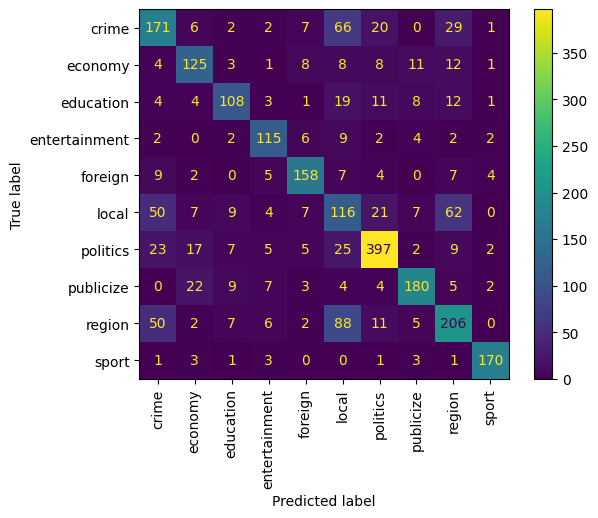

In [94]:
## print confusion matrix
labels = list(label_2_index.keys())

cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=90)

- the result is not so different from logistic regression
- probably because, both logistic regression and NN use only bag-of-words features
- but, NN can get as high score as logistic regression in spite of using only unigrams